# **1. Perkenalan Dataset**


**Informasi Dataset** :
   - Title     : Annotated Corpus for Named Entity Recognition                                                       
   - Source    : https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus
   - Maintener : https://www.kaggle.com/abhinavwalia95
   - Visibility: Publik
   - Usability : 8.53

# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [1]:
import copy, pickle
import warnings
import gdown
warnings.filterwarnings('ignore') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from wordcloud import WordCloud
from collections import Counter
import spacy
from ast import literal_eval
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2025-06-13 21:12:15.079796: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 21:12:16.078577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749823936.442513   31443 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749823936.587795   31443 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749823937.781346   31443 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# **3. Memuat Dataset**

In [2]:
# Memuat dataset dengan pandas read_csv dari hasil download file google drive https://drive.google.com/file/d/1OoaUzSoFI-ZwHMQ55vr3MBpuNDVtJ_CX/view?usp=sharing
file_id = "1OoaUzSoFI-ZwHMQ55vr3MBpuNDVtJ_CX"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "ner.csv", quiet=False)

df = pd.read_csv("ner.csv", encoding = "unicode_escape", on_bad_lines='skip', usecols=['sentence_idx', 'word', 'tag'])
df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1OoaUzSoFI-ZwHMQ55vr3MBpuNDVtJ_CX
From (redirected): https://drive.google.com/uc?id=1OoaUzSoFI-ZwHMQ55vr3MBpuNDVtJ_CX&confirm=t&uuid=ce07de14-2381-4d22-a63a-b790fdcd569a
To: /home/tnl/Work/Laskar AI/SMSML_Tri Nuryatul Lestari/Experimen_SML_Tri Nuryatul Lestari/preprocessing/ner.csv
100%|████████████████████████████████████████████████████████████████████████████████| 157M/157M [00:20<00:00, 7.55MB/s]


,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


**Note hasil memuat dataset**:
1. Parameter encoding="unicode_escape" digunakan untuk menangani karakter spesial atau non-ASCII dalam file CSV yang bisa menyebabkan error.
2. usecols=['sentence_idx', 'word', 'tag'] membatasi kolom yang dimuat agar hanya mencakup kolom penting untuk task NER, sehingga lebih efisien dalam penggunaan memori.
3. on_bad_lines='skip' digunakan untuk melewati baris yang korup atau formatnya tidak sesuai, agar tidak menghentikan proses load dataset.


# **4. Exploratory Data Analysis (EDA)**

### Get General Infro

In [3]:
# Menampilkan 5 row teratas data dari pandas df
df.head()

,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


In [4]:
# Menampilkan ringkasan pandas df dengan cepat
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050796 entries, 0 to 1050795
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentence_idx  1050795 non-null  object
 1   word          1050784 non-null  object
 2   tag           1050795 non-null  object
dtypes: object(3)
memory usage: 24.1+ MB


In [5]:
# Menampilkan ringkasan statistik deskriptif dari pandas df
df.describe()

,sentence_idx,word,tag
count,1050795,1050784,1050795
unique,36685,30172,18
top,2549,the,O
freq,140,52799,889973


In [6]:
# Menampilkan jumlah missing value setiap fitur
print("Jumlah missing value")
print(df.isnull().sum())

Jumlah missing value
sentence_idx     1
word            12
tag              1
dtype: int64


In [7]:
# Menampilkan jumlah duplikat pandas df 
print("Jumlah duplicate data", df.duplicated().sum())

Jumlah duplicate data 303092


**Note hasil get general informasi dari df**:
1. Berdasarkan infomasi di link dataset, dataset ner memiliki 24 fitur
2. Berdasarkan kebutuhan pengembangan ini, fitur yang akan digunakan hanya 3 yaitu sentence_idx, word, dan tag
   Detail Infomasi :
   - Jumlah baris dataset : 1050795
   - Jumlah fitur dataset : 3
   - Jumlah missing value : sentence_idx sebanyak 1, word sebanyak 12, dan tag sebanyak 1
   - Jumlah data duplikat : 303092, banyaknya duplikat ini karena setiap kata dalam kalimat dipecah menjadi baris-baris baru. Dengan banyak kata yang berulang dalam suatu kalimat pada keseluruhan data dengan detail sentence_idx, word, dan tag yang sama membuat informasi yang berulang
   - Tipe data keseluruhan fitur yang digunakan adalah object

### Visualisasi Data

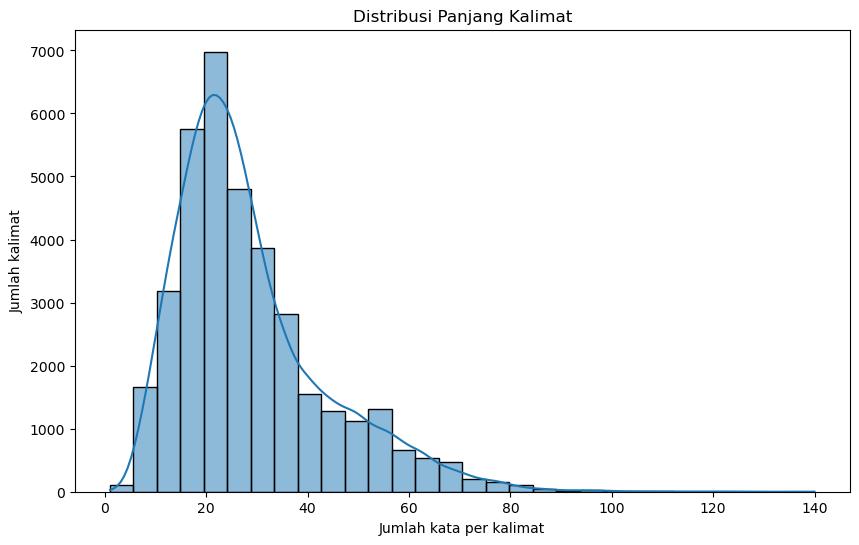

In [8]:
# Visualisasi jumlah kata setiap kalimat
sentence_lengths = df.groupby("sentence_idx")["word"].count()
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title("Distribusi Panjang Kalimat")
plt.xlabel("Jumlah kata per kalimat")
plt.ylabel("Jumlah kalimat")
plt.show()

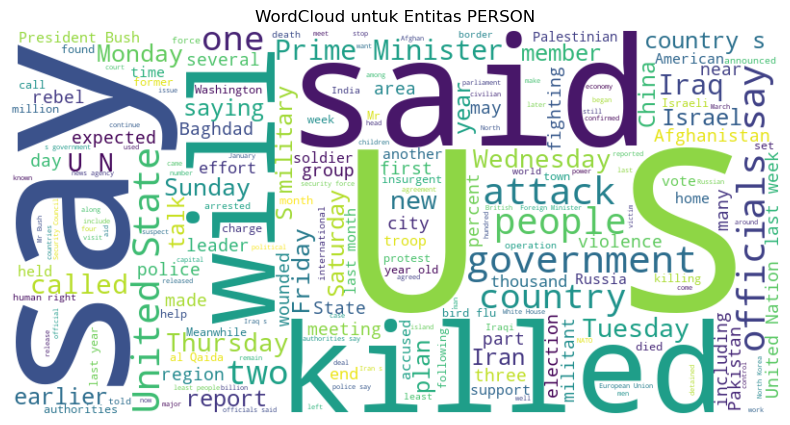

In [9]:
# Visualisasi Worcloud
text = " ".join(df["word"].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud untuk Entitas PERSON")
plt.show()

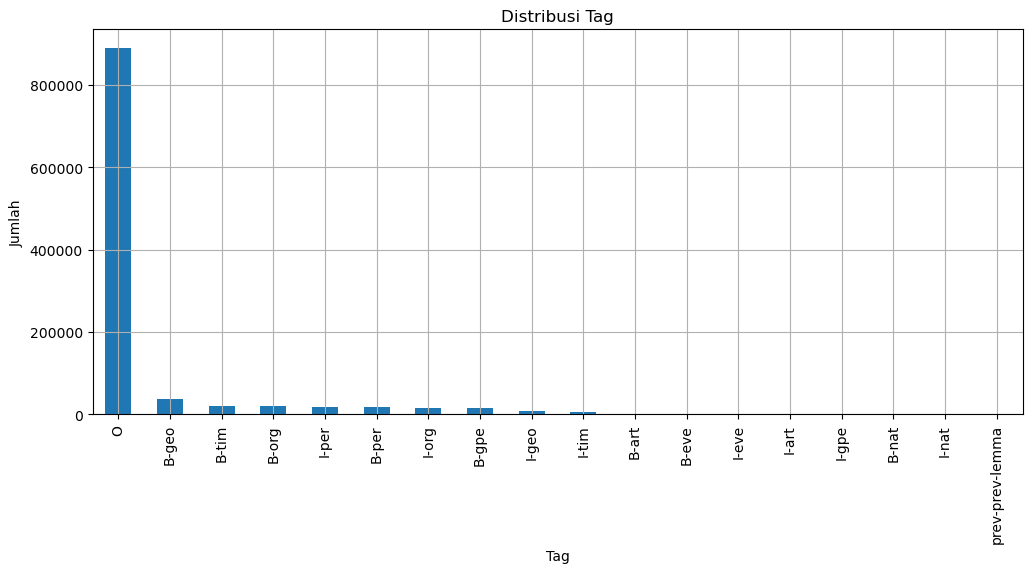

In [10]:
# Visualisasi distribusi tag
tag_counts = df['tag'].value_counts()
tag_counts.plot(kind='bar', figsize=(12, 5), title="Distribusi Tag")
plt.xlabel("Tag")
plt.ylabel("Jumlah")
plt.grid(True)
plt.show()

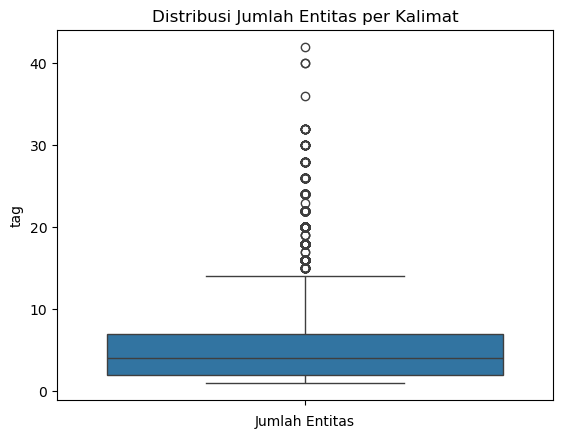

In [11]:
# Visualisasi sebaran jumlah entiti setiap kalimat
entities_per_sentence = df[df['tag'] != 'O'].groupby("sentence_idx")["tag"].count()
sns.boxplot(data=entities_per_sentence)
plt.title("Distribusi Jumlah Entitas per Kalimat")
plt.xlabel("Jumlah Entitas")
plt.show()

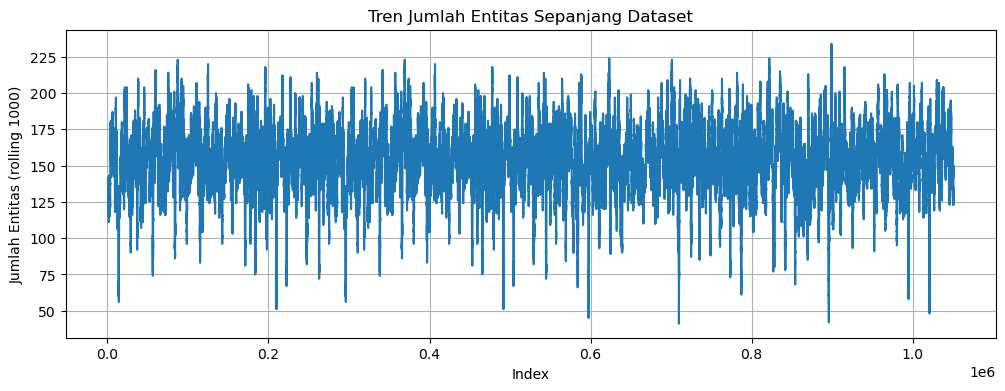

In [12]:
# Visualisasi Tren Jumlah Entities pada Dataset
df_entity = copy.deepcopy(df)
df_entity['Is_Entity'] = df['tag'].apply(lambda x: 0 if x == 'O' else 1)
df_entity['Rolling_Entity_Count'] = df_entity['Is_Entity'].rolling(window=1000).sum()

df_entity['Rolling_Entity_Count'].plot(title="Tren Jumlah Entitas Sepanjang Dataset", figsize=(12, 4))
plt.xlabel("Index")
plt.ylabel("Jumlah Entitas (rolling 1000)")
plt.grid(True)
plt.show()

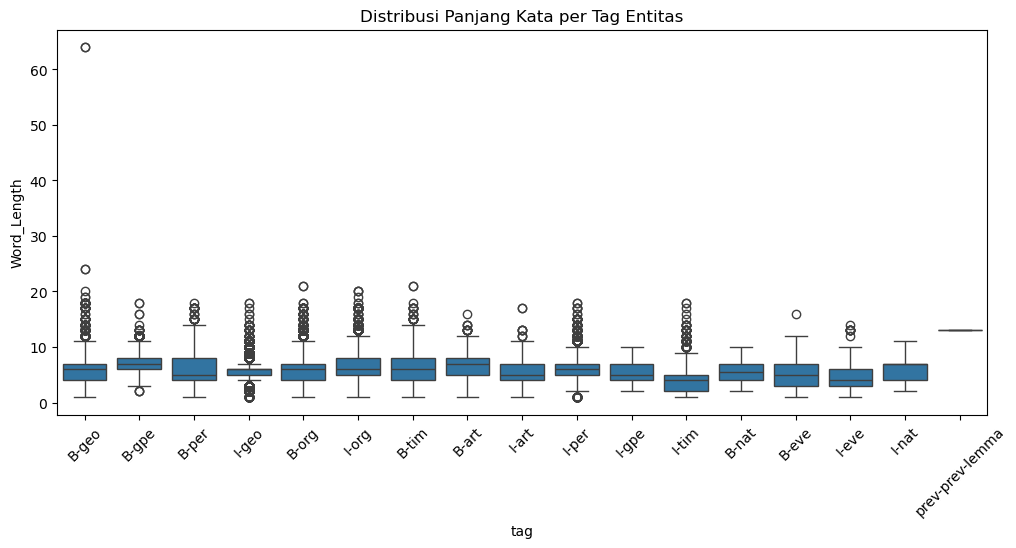

In [13]:
# Visualisasi panjang minimal dan maksimal kata dalam setiap entiti
df_entity['Word_Length'] = df_entity['word'].astype(str).apply(len)
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_entity[df_entity['tag'] != 'O'], x='tag', y='Word_Length')
plt.xticks(rotation=45)
plt.title("Distribusi Panjang Kata per Tag Entitas")
plt.show()

nan


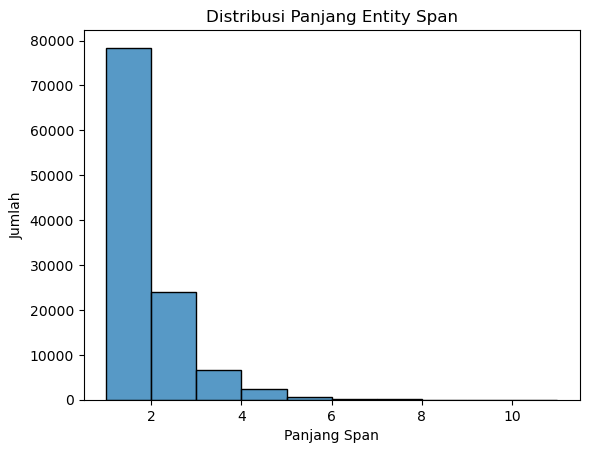

In [14]:
# Visualisasi panjang kata (span) pada entiti
entity_spans = []
length = 0
for tag in df["tag"]:
    try:
        if tag.startswith("B-"):
            if length > 0:
                entity_spans.append(length)
            length = 1
        elif tag.startswith("I-"):
            length += 1
        else:
            if length > 0:
                entity_spans.append(length)
                length = 0
    except:
        print(tag)

sns.histplot(entity_spans, bins=10)
plt.title("Distribusi Panjang Entity Span")
plt.xlabel("Panjang Span")
plt.ylabel("Jumlah")
plt.show()

**Note hasil visualisasi data**:
1. **Distribusi Panjang Kalimat**:
Sebagian besar kalimat dalam dataset memiliki jumlah kata di bawah 20, tetapi terdapat beberapa kalimat yang sangat panjang (di atas 50 kata), menunjukkan adanya variasi panjang konteks.

2. **Frekuensi Tag NER**:
Tag "O" (outside entity) merupakan yang paling sering muncul, menandakan sebagian besar token tidak memiliki entitas. Namun, tag seperti "B-PER", "B-ORG", dan "B-LOC" juga muncul cukup sering, menunjukkan dataset ini memiliki keragaman entitas yang baik.

3. **WordCloud untuk Tag Tertentu**:
WordCloud untuk yang sering muncul yaitu US, said, killed, will dll. Hal ini menunjukkan jumlah kata yang paling banyak muncul tidak didominasi suatu entities, namun ada bukan entitas yang mendominasi

4. **Sebaran Jumlah Entity per Kalimat**:
Sebagian besar kalimat mengandung 1–2 entitas, tetapi ada kalimat yang memiliki hingga 5 entitas, menunjukkan adanya kalimat kompleks yang bisa dimanfaatkan untuk training model yang lebih robust.

5. **Panjang Span Entity**:
Panjang entity span (jumlah token dari B- ke I-) mayoritas hanya 1–2 token, namun terdapat entitas panjang hingga 4–5 token, contohnya nama organisasi atau lokasi panjang.

7. **Distribusi Kalimat per Sentence Index**:
Jumlah kalimat yang diwakili oleh indeks tertentu relatif merata, namun terdapat beberapa indeks dengan outlier jumlah token sangat tinggi.

8. **Token Paling Sering Muncul**:
Token umum seperti "the", "of", dan "in" mendominasi, tetapi juga terlihat nama-nama entitas dalam distribusi token, yang bisa digunakan untuk prefilter fitur atau vocabulary trimming.

# **5. Data Preprocessing**

### Handling Missing Value

In [15]:
# Menghapus tag yang tidak seharusnya
df  = df[df['sentence_idx'] != 'prev-lemma'].dropna(subset=['sentence_idx']).reset_index(drop=True)

In [16]:
# Menghapus kolom dengan value nan
df = df.dropna(subset=["sentence_idx", "word", "tag"])

In [17]:
# Menampilkan jumlah missing value setiap fitur
print("Jumlah missing value")
print(df.isnull().sum())

Jumlah missing value
sentence_idx    0
word            0
tag             0
dtype: int64


**Note hasil handling missing value**:
1. Dilakukan remove value pada fitu sentence_idx yang tidak seharusnya yaitu value fitur `prev-lemma`
2. Handling missing value dilakukan dengan remove data missing value tersebut

### Reformat Dataset untuk Training

In [18]:
# Membuat bentuk kalimat dari data 
words = pd.DataFrame(df.groupby('sentence_idx')['word'].apply(list))
tags = df.groupby('sentence_idx')['tag'].apply(list)
words['tag'] = tags
words['sentence'] = words['word'].apply(lambda x: ' '.join(x))
words['tag_combine'] = words['tag'].apply(lambda x: ' '.join(x))
words = words.reset_index()
words.head()

,sentence_idx,word,tag,sentence,tag_combine
0,1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...",Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,2,"[Families, of, soldiers, killed, in, the, conf...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O O B-per O O ...
2,3,"[They, marched, from, the, Houses, of, Parliam...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo...",They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo O
3,4,"[Police, put, the, number, of, marchers, at, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O O
4,5,"[The, protest, comes, on, the, eve, of, the, a...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,...",The protest comes on the eve of the annual con...,O O O O O O O O O O O B-geo O O B-org I-org O ...


In [19]:
# Tagging Data dengan Spacy
spacy_data = []
for idx, row in words.iterrows():
    tokens = row['word']
    tags = row['tag']
    entities = [
        (len(' '.join(tokens[:i])) + 1, len(' '.join(tokens[:i])) + len(tokens[i]) + 1, tags[i]) 
        if i != 0 else
        (len(' '.join(tokens[:i])), len(' '.join(tokens[:i])) + len(tokens[i]), tags[i])
        for i in range(len(tags)) if tags[i] != 'O'
    ]
    data_tuple = (row['sentence'], {'entities': entities})
    spacy_data.append(data_tuple)
spacy_data[:5] 

[('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
  {'entities': [(48, 54, 'B-geo'), (77, 81, 'B-geo'), (111, 118, 'B-gpe')]}),
 ('Families of soldiers killed in the conflict joined the protesters who carried banners with such slogans as " Bush Number One Terrorist " and " Stop the Bombings . "',
  {'entities': [(109, 113, 'B-per')]}),
 ('They marched from the Houses of Parliament to a rally in Hyde Park .',
  {'entities': [(57, 61, 'B-geo'), (62, 66, 'I-geo')]}),
 ('Police put the number of marchers at 10,000 while organizers claimed it was 1,00,000 .',
  {'entities': []}),
 ("The protest comes on the eve of the annual conference of Britain 's ruling Labor Party in the southern English seaside resort of Brighton .",
  {'entities': [(57, 64, 'B-geo'),
    (75, 80, 'B-org'),
    (81, 86, 'I-org'),
    (103, 110, 'B-gpe'),
    (129, 137, 'B-geo')]})]

In [20]:
def num_words_tags (tags, data):
    
    """This functions takes the tags we want to count and the datafram 
    and return a dict where the key is the tag and the value is the frequency
    of that tag"""
    
    tags_count = {}
    
    for tag in tags:
        len_tag = len(data[data['tag'] == tag])
        tags_count[tag] = len_tag
    
    return tags_count

tags = df["tag"].unique()
tags_count = num_words_tags(tags, df)
tags_count

{'O': 889962,
 'B-geo': 37525,
 'B-gpe': 16392,
 'B-per': 17011,
 'I-geo': 7409,
 'B-org': 20184,
 'I-org': 16537,
 'B-tim': 20193,
 'B-art': 434,
 'I-art': 280,
 'I-per': 17382,
 'I-gpe': 229,
 'I-tim': 6298,
 'B-nat': 226,
 'B-eve': 348,
 'I-eve': 297,
 'I-nat': 76}

**Note hasil reformat dataset**:
1. **Penggabungan Token dan Tag per Kalimat**: 
Dengan groupby('sentence_idx'), token (word) dan label (tag) dikelompokkan menjadi list berdasarkan indeks kalimat, sehingga struktur data berubah dari format baris-per-token menjadi satu baris per kalimat.

2. **Pembuatan Kolom Kalimat dan Tag Gabungan**: 
Dibuat kolom baru bernama sentence yang menggabungkan token dalam satu string kalimat dan tag_combine yang menggabungkan tag menjadi satu string paralel terhadap kalimat.

3. **Reset Index DataFrame**: 
reset_index() digunakan untuk mengatur ulang indeks agar sentence_idx menjadi kolom eksplisit, membuat struktur data lebih rapi dan siap diolah lebih lanjut.

4. **Transformasi Format ke Spacy NER Format**: 
Dilakukan iterasi baris per baris untuk mengubah struktur data menjadi format [(kalimat, {entities: [(start, end, label), ...]})], sesuai format yang dibutuhkan Spacy untuk pelatihan model NER.

5. **Perhitungan Posisi Entity**: 
Start dan end index untuk setiap entity dihitung dengan menjumlahkan panjang token sebelumnya dan spasi di antaranya, sehingga anotasi posisi entitas akurat dalam konteks kalimat utuh.

### Preproses Dataset

In [21]:
words

,sentence_idx,word,tag,sentence,tag_combine
0,1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...",Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,2,"[Families, of, soldiers, killed, in, the, conf...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",Families of soldiers killed in the conflict jo...,O O O O O O O O O O O O O O O O O O B-per O O ...
2,3,"[They, marched, from, the, Houses, of, Parliam...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo...",They marched from the Houses of Parliament to ...,O O O O O O O O O O O B-geo I-geo O
3,4,"[Police, put, the, number, of, marchers, at, 1...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","Police put the number of marchers at 10,000 wh...",O O O O O O O O O O O O O O O
4,5,"[The, protest, comes, on, the, eve, of, the, a...","[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,...",The protest comes on the eve of the annual con...,O O O O O O O O O O O B-geo O O B-org I-org O ...
...,...,...,...,...,...
36679,95,"[Officials, say, one, suspect, was, arrested, .]","[O, O, O, O, O, O, O]",Officials say one suspect was arrested .,O O O O O O O
36680,96,"[In, Rome, ,, a, Vatican, spokesman, deplored,...","[O, B-geo, O, O, B-org, O, O, O, O, O, O, O, O...","In Rome , a Vatican spokesman deplored the att...",O B-geo O O B-org O O O O O O O O O O O O O O ...
36681,97,"[Authorities, in, Mogadishu, have, not, determ...","[O, O, B-geo, O, O, O, O, O, O, O, O, O]",Authorities in Mogadishu have not determined a...,O O B-geo O O O O O O O O O
36682,98,"[The, pope, has, said, he, meant, no, offense,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",The pope has said he meant no offense to Musli...,O O O O O O O O O O O O O O O O B-per O O O O ...


In [22]:
# Membuat variable X dan Y dari kolom sentence dan tag
X = list(words['sentence'])
Y = list(words['tag'])

In [23]:
Y_ready = []
for sen_tags in Y:
    Y_ready.append(literal_eval(str(sen_tags)))

In [24]:
# Mengatur panjang maksimal setiap kalimat hanya 110 token
maxlen = 110

# Mengatur maksimal banyak token 
max_words = 36000

# Tokenize kalimat pada dataset
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
print(tokenizer)

In [25]:
# Save tokenizer for prediction
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [26]:
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 24381 unique tokens.


In [27]:
ind2word = dict([(value, key) for (key, value) in word_index.items()])
word2id = word_index
id2word = {}
for key, value in word2id.items():
    id2word[value] = key

In [43]:
X_preprocessed = pad_sequences(sequences, maxlen=maxlen, padding='post')
X_preprocessed[0]

array([ 265,    3,  938,   13, 1994,  249,  457,    4,  512,    1,  122,
          2,   59,    6,  662,    1,  830,    3,  183,   91,   20,   12,
         52,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [44]:
tags2id = {}
for i, tag in enumerate(tags):
    tags2id[tag] = i
tags2id

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [45]:
id2tag = {}
for key, value in tags2id.items():
    id2tag[value] = key
id2tag

{0: 'O',
 1: 'B-geo',
 2: 'B-gpe',
 3: 'B-per',
 4: 'I-geo',
 5: 'B-org',
 6: 'I-org',
 7: 'B-tim',
 8: 'B-art',
 9: 'I-art',
 10: 'I-per',
 11: 'I-gpe',
 12: 'I-tim',
 13: 'B-nat',
 14: 'B-eve',
 15: 'I-eve',
 16: 'I-nat'}

In [46]:
def preprocess_tags(tags2id, Y_ready):
    Y_preprocessed = []
    maxlen = 110
    i = 0
    # for each target 
    for y in Y_ready:
        j = 0
        # place holder to store the new preprocessed tag list
        Y_place_holder = []
        
        # for each tag in rhe tag list 
        for tag in y:
            if(j >= 110):
                pass
            else:
                Y_place_holder.append(tags2id[tag])
            j +=1
        
        # find the lenght of the new preprocessed tag list 
        len_new_tag_list = len(Y_place_holder)
        # find the differance in length between the len of tag list and padded sentences
        num_O_to_add = maxlen - len_new_tag_list
        
        # add 'O's to padd the tag lists
        padded_tags = Y_place_holder + ([tags2id['O']] * num_O_to_add)
        Y_preprocessed.append(padded_tags)
        
    return Y_preprocessed

In [47]:
Y_preprocessed = preprocess_tags(tags2id, Y_ready)
print("The Lenght of training examples: {}".format(len(X_preprocessed)))
print("The Lenght of training targets: {}".format(len(Y_preprocessed)))

The Lenght of training examples: 36684
The Lenght of training targets: 36684


In [48]:
X_preprocessed = np.asarray(X_preprocessed)
Y_preprocessed = np.asarray(Y_preprocessed)

**Note hasil split dan preproses dataset**:
1. Tokenize untuk mengubah kalimat (sentence) menjadi urutan angka (ID) menggunakan Tokenizer dari Keras atau tokenizer BERT
2. Label atau tag NER (seperti B-PER, O, I-ORG), dengan function tag2idx, telah diubah menjadi angka
3. Karena panjang kalimat bervariasi, untuk menyamakan panjang semua sequence (baik untuk X maupun Y) dilakuakn proses ped_squence dengan function pad_sequences tensorflow. Maksimal padding yaitu 110 (maxlen) yang telah ditetapkan secara manual
4. Penggunaan padding "post" agar padding (0) ditempatkan di akhir kalimat.

### Split Dataset

In [53]:
# Split Data menjadi train dan test
indices = np.arange(len(Y_preprocessed))
np.random.seed(seed=555)
np.random.shuffle(indices)
X_preprocessed = X_preprocessed[indices]
Y_preprocessed = Y_preprocessed[indices]

X_train, X_test, Y_train, Y_test = train_test_split(X_preprocessed, Y_preprocessed, test_size=0.2, random_state=42)

print("Number of training examples: {}".format(len(X_train)))
print("Number of testing examples: {}".format(len(X_test)))
print("Total number of examples after shuffling and splitting: {}".format(len(X_train)+ len(X_test)))

Number of training examples: 29347
Number of testing examples: 7337
Total number of examples after shuffling and splitting: 36684


In [54]:
# Simpan semuanya sebagai dictionary
data = {
    "X_train": X_train,
    "Y_train": Y_train,
    "X_test": X_test,
    "Y_test": Y_test
}

In [55]:
# simpan data dalam format pickle
with open("ner_dataset_split.pkl", "wb") as f:
    pickle.dump(data, f)

**Note hasil split dan preproses dataset**:
1. Setelah tokenisasi dan padding, array X_preprocessed dan Y_preprocessed diacak (shuffle) agar data tidak sesuai urutan asli
2. X_preprocessed dan Y_preprocessed kemudian dibagi menjadi data train, test, dan validasi
3. Prosentase setiap data yaitu train 70%, test dan validasi masing-masing 15%
